In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import squints as sq

## Data Loading

In [2]:
train_o = pd.read_csv("data/train.csv")
test_o = pd.read_csv("data/test.csv")

In [3]:
prepr = lambda data:sq.logize(sq.fillize(sq.relize(sq.deidize(data))))

ftrainX, ftrainY = prepr(train_o.drop("y",axis=1)), train_o["y"]
ftrainX, ftestX = sq.normall([ftrainX, prepr(test_o)])

trainX, valX, trainY, valY = sq.splitize(train_o)
trainX, valX, testX = sq.normall([prepr(trainX), prepr(valX), prepr(test_o)])

In [4]:
class StockDataset(Dataset):
    def __init__(self, x, y):
        self.X = torch.tensor(x.values.astype(np.float32), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):       
        return (self.X[idx],
                self.y[idx]
               )

In [11]:
bsize = 32

train = DataLoader(StockDataset(trainX, trainY), batch_size=bsize, shuffle=True)
val = DataLoader(StockDataset(valX, valY), batch_size=bsize, shuffle=True)
ftrain = DataLoader(StockDataset(ftrainX, ftrainY), batch_size=bsize)

## Train

In [6]:
def mfit(model, train, val=None, lr=1e-3, nepochs=10):
    #model.cuda()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    s_train = np.zeros(nepochs)
    s_val = np.zeros(nepochs)
    for epoch in range(nepochs):
        model.train()
        for i, (data, target) in enumerate(train):
            #data, target = data.cuda(), target.cuda()
            if (i % int(len(train)/20) == 0):
                print(f"{int(i/len(train)*20)} ", end="")
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

        if (val is not None):
            s_val[epoch] = meval(model, val)
        s_train[epoch] = meval(model, train)
        print(s_train[epoch], s_val[epoch])
    return s_train, s_val

import sklearn.metrics
def meval(model, data, nsamp=8):
    model.eval()
    bsize = data.batch_size
    outs = torch.zeros(nsamp*bsize)
    targets = torch.zeros(nsamp*bsize)
    sm = nn.Softmax(dim=1)
    for i, (data, target) in enumerate(data):
        if (i >= nsamp):
            break
        outs[i*bsize:(i+1)*bsize] = sm(model(data).detach())[:,1]
        targets[i*bsize:(i+1)*bsize] = target
    return sklearn.metrics.roc_auc_score(targets, outs)

In [7]:
layers = [
    nn.Linear(27, 10),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(5,2)
]

In [8]:
model = nn.Sequential(*layers)
strain, sval = mfit(model, train, val, nepochs=3, lr=1e-4)

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6203626799557032 0.6323728354978355
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6946291925910034 0.5597603279722484
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.7052878179384204 0.6418340026773761


## Predict

In [12]:
ttrain = torch.tensor(ftrainX.values.astype(np.float32))
ttest = torch.tensor(testX.values.astype(np.float32))

In [13]:
fmodel = nn.Sequential(*layers)
fstrain, fsval = mfit(fmodel, train, nepochs=3, lr=1e-4)

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.5866279069767442 0.0
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6028701625518601 0.0
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6958096590909091 0.0


In [14]:
def toprob(p):
    sm = nn.Softmax(dim=1)
    return sm(p.detach())[:,1]

fptrain = toprob(fmodel(ttrain))
fptest = toprob(fmodel(ttest))

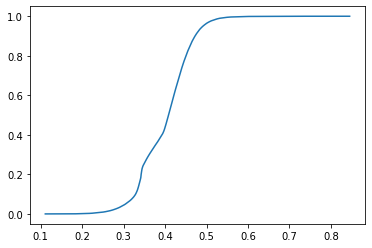

In [15]:
sq.ecdf(fptest)

In [16]:
sq.write(train_o["id"], fptrain, "torch-train.csv")
sq.write(test_o["id"], fptest, "torch-test.csv")